In [1]:
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np
import cv2 as cv
import random
import os

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# def resize_image(path, save_path):

    
#     for root, dirs, files in os.walk(path):

#         for name in dirs:
            
#             direct = os.path.join(path, name)
            
#             for filename in os.listdir(direct):
                
#                 img = Image.open(os.path.join(path + "/" + name, filename))
#                 img = img.resize((224,224))
                
#                 # images.append(img)
#                 # filenames.append(name + '/' + filename)
#                 if not os.path.exists(save_path):
#                     os.makedirs(save_path)
#                 if not os.path.exists(save_path + name):
#                     os.makedirs(save_path + name)
#                 img.save(save_path + name + '/' + filename)

In [4]:
# resize_image(path=train_path, save_path='./processed image/' )

In [5]:
Image_Width=224   #600
Image_Height=224  #400
Image_Size=(Image_Width,Image_Height)
Image_Channels=3
batch_size = 32

In [6]:
def read_image(path, images, labels, filenames):
    
    for root, dirs, files in os.walk(path):

        for name in dirs:
            
            direct = os.path.join(path, name)
            
            for filename in os.listdir(direct):
                
                img = cv.imread(os.path.join(path + "/" + name, filename))
                labels.append(name)
                img = cv.resize(img, Image_Size)
                images.append(img)
                filenames.append(name + '/' + filename)

In [7]:
def create_dataframe(filenames, labels):
    
    df = pd.DataFrame({
        
    'filename' : filenames,
    'category' : labels

    })
    
    return df

In [8]:
def draw_countplot(dataframe, y_axis, title):
    
    sns.countplot(data=dataframe, y = y_axis, width=0.3, palette = 'Set2')
    plt.title(title, weight='black')
    plt.show()

In [9]:
train_filenames = []
train_images = []
train_labels = []
train_path = './processed image/'

read_image(path=train_path, images=train_images, labels=train_labels, filenames=train_filenames)

### Train Data

In [10]:
train_df = create_dataframe(filenames=train_filenames, labels=train_labels)
train_df

,filename,category
0,Melanoma/AUGmented_0_1000.jpeg,Melanoma
1,Melanoma/AUGmented_0_1007.jpeg,Melanoma
2,Melanoma/AUGmented_0_1009.jpeg,Melanoma
3,Melanoma/AUGmented_0_1022.jpeg,Melanoma
4,Melanoma/AUGmented_0_1029.jpeg,Melanoma
...,...,...
10677,NotMelanoma/ISIC_0034314.jpg,NotMelanoma
10678,NotMelanoma/ISIC_0034315.jpg,NotMelanoma
10679,NotMelanoma/ISIC_0034318.jpg,NotMelanoma
10680,NotMelanoma/ISIC_0034319.jpg,NotMelanoma


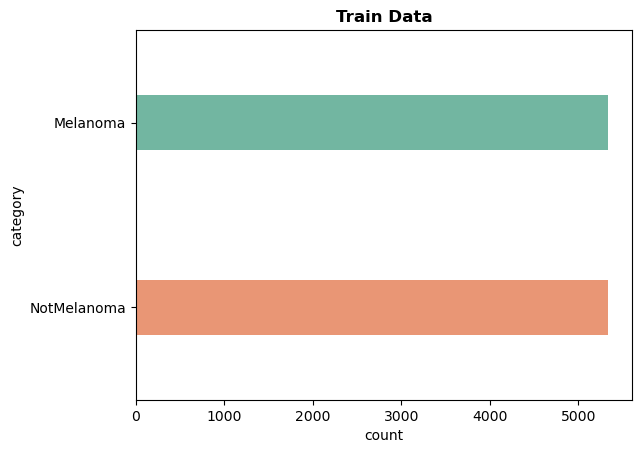

In [11]:
draw_countplot(dataframe=train_df, y_axis='category', title='Train Data')

In [12]:
test_filenames = []
test_images = []
test_labels = []
test_path = './DermMel/test/'

read_image(path=test_path, images=test_images, labels=test_labels, filenames=test_filenames)

### Test Data

In [13]:
test_df = create_dataframe(filenames=test_filenames, labels=test_labels)
test_df

,filename,category
0,Melanoma/AUGmented_0_1015.jpeg,Melanoma
1,Melanoma/AUGmented_0_1036.jpeg,Melanoma
2,Melanoma/AUGmented_0_1093.jpeg,Melanoma
3,Melanoma/AUGmented_0_1110.jpeg,Melanoma
4,Melanoma/AUGmented_0_1114.jpeg,Melanoma
...,...,...
3556,NotMelanoma/ISIC_0034257.jpg,NotMelanoma
3557,NotMelanoma/ISIC_0034260.jpg,NotMelanoma
3558,NotMelanoma/ISIC_0034278.jpg,NotMelanoma
3559,NotMelanoma/ISIC_0034309.jpg,NotMelanoma


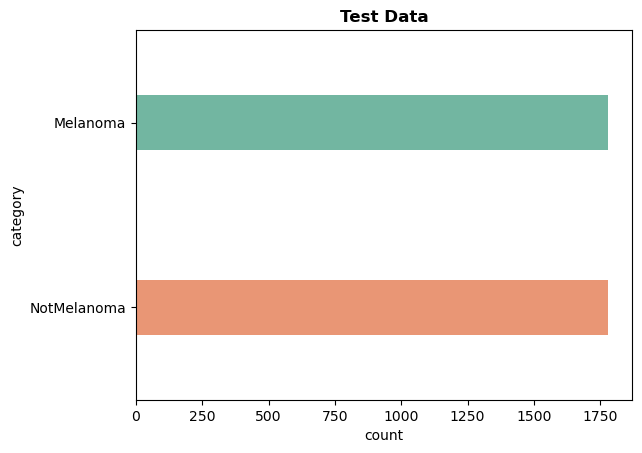

In [14]:
draw_countplot(dataframe=test_df, y_axis='category', title='Test Data')

In [15]:
#preprocessing
train_datag=ImageDataGenerator(rescale=1./ 255,
                              horizontal_flip = True,
                               vertical_flip = True,
                               rotation_range = 25,
                              )#rescalling

train_dataset=train_datag.flow_from_dataframe(dataframe=train_df, #data_frame of data
                                              directory=train_path, #path
                                              x_col="filename",
                                              y_col="category",
                                              color_mode='rgb',
                                              target_size=Image_Size, #resize image it doesnt mean converting into 2d we can give only height and breadth
                                              batch_size=32, #by default 32
                                              # validate_filenames= False
                                             )

Found 10682 validated image filenames belonging to 2 classes.


In [16]:
test_datag=ImageDataGenerator(rescale=1./255)
test_dataset=test_datag.flow_from_dataframe(dataframe=test_df,
                                            directory=test_path,
                                            x_col="filename",
                                            y_col="category",
                                            color_mode='rgb',
                                            target_size=Image_Size,
                                            batch_size=32,
                                            validate_filenames=False,
                                            shuffle=False,
                                            class_mode='categorical',
                                           )

Found 3561 non-validated image filenames belonging to 2 classes.


In [17]:
train_dataset.class_indices #gives the class of target values

{'Melanoma': 0, 'NotMelanoma': 1}

In [18]:
train_dataset[0][0].shape# 0 batch# 32 batches 128-h 128-w,3d image

(32, 224, 224, 3)

In [19]:
conv_base = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
)

for layer in conv_base.layers:
    layer.trainable = False
    
    
model = Sequential()

model.add(conv_base)

model.add(Flatten())

model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [20]:
adam_optimizer = Adam(learning_rate = 0.00003)
model.compile(loss="CategoricalCrossentropy",optimizer=adam_optimizer, metrics=["accuracy", Precision()])

In [21]:
train_dataset[0][0][0][0][0]

array([0.99689955, 0.9310539 , 0.9624265 ], dtype=float32)

In [22]:
del train_images
del test_images
del train_df
del train_filenames
del test_filenames
del train_labels
del test_labels

In [23]:
with tf.device('/cpu:0'):
    history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/15
334/334 [==============================] - 660s 2s/step - loss: 0.4648 - accuracy: 0.7863 - precision: 0.7863 - val_loss: 0.3893 - val_accuracy: 0.8318 - val_precision: 0.8318
Epoch 2/15
334/334 [==============================] - 663s 2s/step - loss: 0.3796 - accuracy: 0.8296 - precision: 0.8296 - val_loss: 0.3581 - val_accuracy: 0.8287 - val_precision: 0.8287
Epoch 3/15
334/334 [==============================] - 662s 2s/step - loss: 0.3561 - accuracy: 0.8475 - precision: 0.8475 - val_loss: 0.3588 - val_accuracy: 0.8349 - val_precision: 0.8349
Epoch 4/15
334/334 [==============================] - 661s 2s/step - loss: 0.3398 - accuracy: 0.8535 - precision: 0.8535 - val_loss: 0.3033 - val_accuracy: 0.8675 - val_precision: 0.8675
Epoch 5/15
334/334 [==============================] - 661s 2s/step - loss: 0.3217 - accuracy: 0.8635 - precision: 0.8635 - val_loss: 0.3455 - val_accuracy: 0.8526 - val_precision: 0.8526
Epoch 6/15
334/334 [==============================] - 662s 2s/ste

In [24]:
model.save("melanoma-VGG16base.h5")
print("Saved model to disk")

Saved model to disk


In [25]:
validation_filenames = []
validation_images = []
validation_labels = []
validation_path = './DermMel/valid/'

read_image(path=validation_path, images=validation_images, labels=validation_labels, filenames=validation_filenames)

### Validation Data

In [26]:
val_df = create_dataframe(filenames=validation_filenames, labels=validation_labels)
val_df

,filename,category
0,Melanoma/AUGmented_0_1006.jpeg,Melanoma
1,Melanoma/AUGmented_0_1058.jpeg,Melanoma
2,Melanoma/AUGmented_0_110.jpeg,Melanoma
3,Melanoma/AUGmented_0_1108.jpeg,Melanoma
4,Melanoma/AUGmented_0_1140.jpeg,Melanoma
...,...,...
3557,NotMelanoma/ISIC_0034292.jpg,NotMelanoma
3558,NotMelanoma/ISIC_0034297.jpg,NotMelanoma
3559,NotMelanoma/ISIC_0034305.jpg,NotMelanoma
3560,NotMelanoma/ISIC_0034308.jpg,NotMelanoma


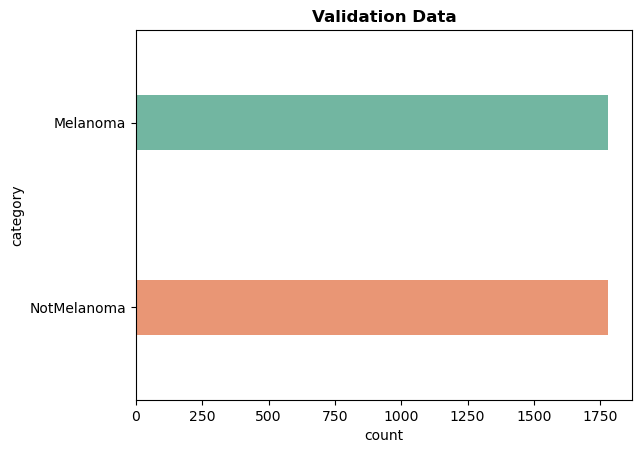

In [27]:
draw_countplot(dataframe=val_df, y_axis='category', title='Validation Data')

In [28]:
val_datag=ImageDataGenerator(rescale=1./255)
val_dataset=val_datag.flow_from_dataframe(dataframe=val_df,
                                            directory=validation_path,
                                            x_col="filename",
                                            y_col="category",
                                            target_size=Image_Size,
                                            batch_size=32,
                                            validate_filenames=False,
                                            shuffle=False,
                                            class_mode='categorical',
                                           )

Found 3562 non-validated image filenames belonging to 2 classes.


In [29]:
test_dataset.class_indices

{'Melanoma': 0, 'NotMelanoma': 1}

In [30]:
val_dataset.class_indices

{'Melanoma': 0, 'NotMelanoma': 1}

In [31]:
with tf.device('/cpu:0'):
    test_pred=model.predict(test_dataset)

112/112 [==============================] - 161s 1s/step


In [32]:
test_df["predict"]=np.argmax(test_pred,axis=1)

In [33]:
test_df["predict_c"]=test_df["predict"].map({0:"Melanoma",1:"NotMelanoma"})

In [34]:
test_df

,filename,category,predict,predict_c
0,Melanoma/AUGmented_0_1015.jpeg,Melanoma,0,Melanoma
1,Melanoma/AUGmented_0_1036.jpeg,Melanoma,0,Melanoma
2,Melanoma/AUGmented_0_1093.jpeg,Melanoma,0,Melanoma
3,Melanoma/AUGmented_0_1110.jpeg,Melanoma,0,Melanoma
4,Melanoma/AUGmented_0_1114.jpeg,Melanoma,0,Melanoma
...,...,...,...,...
3556,NotMelanoma/ISIC_0034257.jpg,NotMelanoma,0,Melanoma
3557,NotMelanoma/ISIC_0034260.jpg,NotMelanoma,1,NotMelanoma
3558,NotMelanoma/ISIC_0034278.jpg,NotMelanoma,0,Melanoma
3559,NotMelanoma/ISIC_0034309.jpg,NotMelanoma,1,NotMelanoma


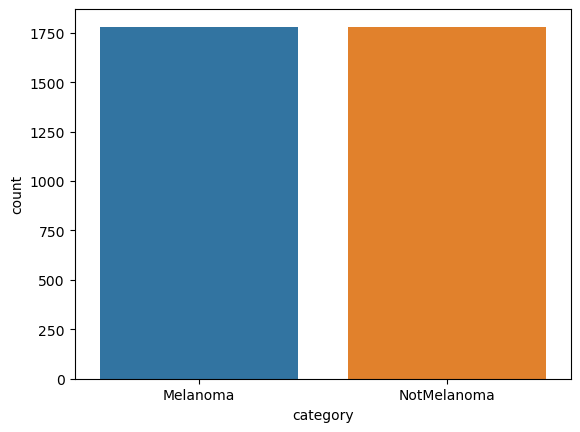

In [35]:
sns.countplot(data=test_df, x='category')
plt.show()

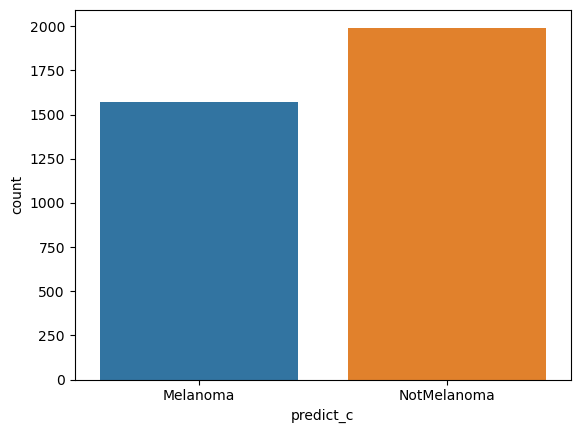

In [36]:
sns.countplot(data=test_df, x='predict_c')
plt.show()

In [37]:
with tf.device('/cpu:0'):
    val_pred=model.predict(val_dataset)

112/112 [==============================] - 160s 1s/step


In [38]:
val_df["predict"]=np.argmax(val_pred,axis=1)

In [39]:
val_df["predict_c"]=val_df["predict"].map({0:"Melanoma",1:"NotMelanoma"})

In [40]:
val_df

,filename,category,predict,predict_c
0,Melanoma/AUGmented_0_1006.jpeg,Melanoma,0,Melanoma
1,Melanoma/AUGmented_0_1058.jpeg,Melanoma,1,NotMelanoma
2,Melanoma/AUGmented_0_110.jpeg,Melanoma,0,Melanoma
3,Melanoma/AUGmented_0_1108.jpeg,Melanoma,0,Melanoma
4,Melanoma/AUGmented_0_1140.jpeg,Melanoma,0,Melanoma
...,...,...,...,...
3557,NotMelanoma/ISIC_0034292.jpg,NotMelanoma,1,NotMelanoma
3558,NotMelanoma/ISIC_0034297.jpg,NotMelanoma,1,NotMelanoma
3559,NotMelanoma/ISIC_0034305.jpg,NotMelanoma,1,NotMelanoma
3560,NotMelanoma/ISIC_0034308.jpg,NotMelanoma,1,NotMelanoma


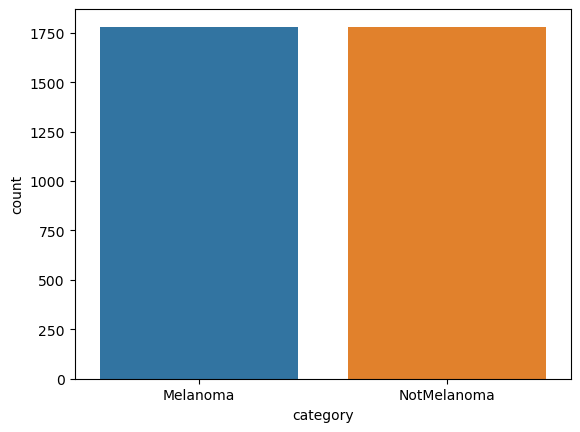

In [41]:
sns.countplot(data=val_df, x='category')
plt.show()

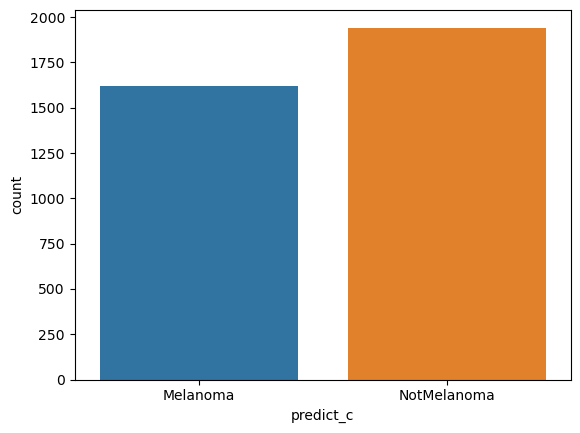

In [42]:
sns.countplot(data=val_df, x='predict_c')
plt.show()

In [43]:
val_df['predict_c'].value_counts()

NotMelanoma    1942
Melanoma       1620
Name: predict_c, dtype: int64

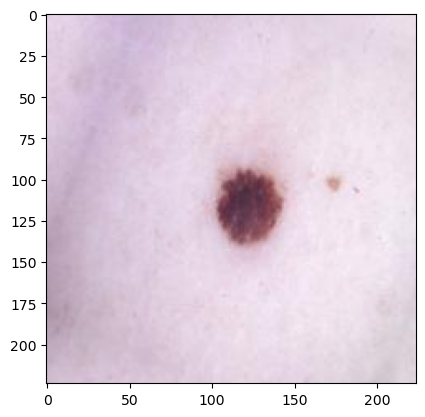

In [44]:
img = plt.imread('./DermMel/valid/Melanoma/AUGmented_0_1058.jpeg')
plt.imshow(img)
plt.show()

In [45]:
print(classification_report(y_pred=val_df['predict_c'], y_true=val_df['category']))

              precision    recall  f1-score   support

    Melanoma       0.93      0.84      0.88      1781
 NotMelanoma       0.86      0.93      0.89      1781

    accuracy                           0.89      3562
   macro avg       0.89      0.89      0.89      3562
weighted avg       0.89      0.89      0.89      3562



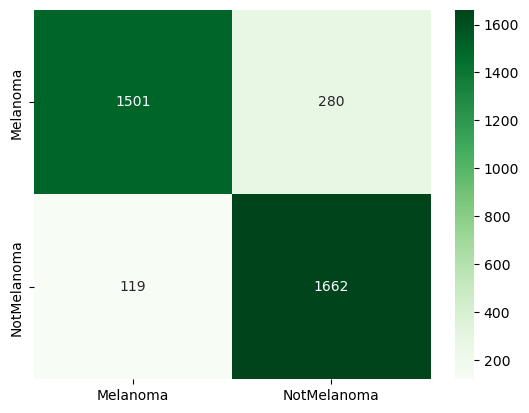

In [50]:
sns.heatmap(confusion_matrix(y_pred=val_df['predict_c'], y_true=val_df['category']), annot=True, xticklabels=val_df['category'].unique(), yticklabels=val_df['category'].unique(), cmap='Greens', fmt='')
plt.show()

In [49]:
print(confusion_matrix(y_pred=val_df['predict_c'], y_true=val_df['category']))

[[1501  280]
 [ 119 1662]]
